<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">


# Dask DataFrame - parallelized pandas

Looks and feels like the pandas API, but for parallel and distributed workflows. 

At its core, the `dask.dataframe` module implements a "blocked parallel" `DataFrame` object that looks and feels like the pandas API, but for parallel and distributed workflows. One Dask `DataFrame` is comprised of many in-memory pandas `DataFrame`s separated along the index. One operation on a Dask `DataFrame` triggers many pandas operations on the constituent pandas `DataFrame`s in a way that is mindful of potential parallelism and memory constraints.


<img src="https://docs.dask.org/en/stable/_images/dask-dataframe.svg"
     align="right"
     width="30%"
     alt="Dask DataFrame is composed of pandas DataFrames"/>

**Related Documentation**

* [DataFrame documentation](https://docs.dask.org/en/latest/dataframe.html)
* [DataFrame screencast](https://youtu.be/AT2XtFehFSQ)
* [DataFrame API](https://docs.dask.org/en/latest/dataframe-api.html)
* [DataFrame examples](https://examples.dask.org/dataframe.html)
* [pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)

## When to use `dask.dataframe`

pandas is great for tabular datasets that fit in memory. A general rule of thumb for pandas is:

> "Have 5 to 10 times as much RAM as the size of your dataset"
>
> ~ Wes McKinney (2017) in [10 things I hate about pandas](https://wesmckinney.com/blog/apache-arrow-pandas-internals/)

Here "size of dataset" means dataset size on _the disk_.

Dask becomes useful when the datasets exceed the above rule.

In this notebook, you will be working with the New York City Airline data. This dataset is only ~200MB, so that you can download it in a reasonable time, but `dask.dataframe` will scale to  datasets **much** larger than memory.



## Set up your local cluster

### Exercise 1


Create a local Dask cluster and connect it to the client. Don't worry about this bit of code for now, you will learn more in the Distributed notebook.

In [1]:
from dask.distributed import LocalCluster

cluster = LocalCluster()
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 10,Total memory: 64.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:54106,Workers: 0
Dashboard: http://127.0.0.1:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:54122,Total threads: 2
Dashboard: http://127.0.0.1:54128/status,Memory: 12.80 GiB
Nanny: tcp://127.0.0.1:54110,


2026-01-19 13:15:40,606 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3db0b756638a84d84430d48301334b0c initialized by task ('shuffle-transfer-3db0b756638a84d84430d48301334b0c', 4) executed on worker tcp://127.0.0.1:54121
2026-01-19 13:15:40,815 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle 3db0b756638a84d84430d48301334b0c deactivated due to stimulus 'task-finished-1768846540.814343'
2026-01-19 13:15:46,843 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:54122' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('read-fused-_to_string_dtype-d26c9c1cd6053a7daf46e012ad20f533', 5), ('read-fused-_to_string_dtype-d26c9c1cd6053a7daf46e012ad20f533', 0)} (stimulus_id='handle-worker-cleanup-1768846546.843791')
2026-01-19 13:15:46,844 - distributed.scheduler - WARNING - Removing worker 'tcp://127.0.0.1:54124' caused the cluster to lose already computed task(s), which will be recomputed elsewhere: {('read-fused

#### Dask Diagnostic Dashboard

Dask Distributed provides a useful Dashboard to visualize the state of your cluster and computations.

Just click on the dashboard link displayed in the Client details above: http://127.0.0.1:8787/status. It will open a new browser tab with the Dashboard.

## Reading and working with datasets

### Exercise 2

Let's analyze some data using extract of flights in the USA across several years. This data is specific to flights out of the three airports in the New York City area. 

To begin, download [NYC Flight data here](https://storage.googleapis.com/dask-tutorial-data/nycflights.tar.gz), and unzip it somewhere you can find it. 


Let's read an extract of flights in the USA across several years. This data is specific to flights out of the three airports in the New York City area.

By convention, we import the module `dask.dataframe` as `dd`.

The following filename includes a glob pattern `*`, so all files in the path matching that pattern will be read into the same `DataFrame`. For example, on my computer I'm using the path `"/users/nce8/downloads/nycflights/*.csv"`.

Load the data, then call the dataframe the way you would normally (e.g., just type `flights` or whatever you called your dataframe).

In [2]:
import dask.dataframe as dd

flights = dd.read_csv("/users/nce8/downloads/nycflights/*.csv")
flights

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,,,
,int64,int64,int64,int64,float64,int64,float64,int64,string,int64,float64,float64,int64,float64,float64,float64,string,string,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


As you (should) see, Dask has not loaded the data yet, so you'll see empty rows.

Basically, dask has:

- investigated the input path and found that there are ten matching files
- intelligently created a set of jobs for each chunk -- one per original CSV file in this case

## Lazy Evaluation

Most Dask Collections, including Dask `DataFrame` are evaluated lazily, which means Dask constructs the logic (called task graph) of your computation immediately but "evaluates" them  only when necessary. You can view this task graph using `.visualize()`. (you may be asked to run `conda install python-graphviz`).

You will learn more about this in the Delayed notebook, but for now, note that we need to call `.compute()` to trigger actual computations.

Some functions like `len` and `head` also trigger a computation. Specifically, calling `len` will:
- load actual data, (that is, load each file into a pandas DataFrame)
- then apply the corresponding functions to each pandas DataFrame (also known as a partition)
- combine the subtotals to give you the final grand total

Try using `len` to get the number of rows in the dataframe.

In [3]:
# load and count number of rows
# len(flights)

You *should* get a bit of an error:

```python
 
 

len(flights)

# ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

# +----------------+---------+----------+
# | Column         | Found   | Expected |
# +----------------+---------+----------+
# | CRSElapsedTime | float64 | int64    |
# | TailNum        | object  | float64  |
# +----------------+---------+----------+

# The following columns also raised exceptions on conversion:

# - TailNum
#   ValueError("could not convert string to float: 'N54711'")

# Usually this is due to dask's dtype inference failing, and
# *may* be fixed by specifying dtypes manually by adding:

# dtype={'CRSElapsedTime': 'float64',
#        'TailNum': 'object'}

# to the call to `read_csv`/`read_table`.

```

Unlike `pandas.read_csv` which reads in the entire file before inferring datatypes, `dask.dataframe.read_csv` only reads in a sample from the beginning of the file (or first file if using a glob). These inferred datatypes are then enforced when reading all partitions.

In this case, the datatypes inferred in the sample are incorrect. The first `n` rows have no value for `CRSElapsedTime` (which pandas infers as a `float`), and later on turn out to be strings (`object` dtype). Note that Dask gives an informative error message about the mismatch. When this happens you have a few options:

- Specify dtypes directly using the `dtype` keyword. This is the recommended solution, as it's the least error prone (better to be explicit than implicit) and also the most performant.
- Increase the size of the `sample` keyword (in bytes)
- Use `assume_missing` to make `dask` assume that columns inferred to be `int` (which don't allow missing values) are actually `floats` (which do allow missing values). In our particular case this doesn't apply.

In our case we'll use the first option and directly specify the `dtypes` of the offending columns. 

Load the data again, this time specifying `dtype`, and then ask for the `len`:

In [4]:
flights = dd.read_csv(
    "/users/nce8/downloads/nycflights/*.csv",
    dtype={"TailNum": str, "CRSElapsedTime": float},
)

In [5]:
len(flights)

2611892

### Reading from remote storage

If you're thinking about distributed computing, your data is probably stored remotely on services (like Amazon's S3 or Google's cloud storage) and is in a friendlier format (like Parquet). Dask can read data in various formats directly from these remote locations **lazily** and **in parallel**.

Here's how you can read the NYC taxi cab data from Amazon S3:

```python
flights = dd.read_parquet(
    "s3://nyc-tlc/trip data/yellow_tripdata_2012-*.parquet",
)
```

You can also leverage Parquet-specific optimizations like column selection and metadata handling, learn more in [the Dask documentation on working with Parquet files](https://docs.dask.org/en/stable/dataframe-parquet.html).

## Computations with `dask.dataframe`

Let's compute the maximum of the flight delay.

With just pandas, we would loop over each file to find the individual maximums, then find the final maximum over all the individual maximums.

```python
import pandas as pd

files = os.listdir("/users/nce8/downloads/nycflights")

maxes = []

for file in files:
    df = pd.read_csv(f"/users/nce8/downloads/nycflights/{file}"))
    maxes.append(df.DepDelay.max())
    
final_max = max(maxes)
```

`dask.dataframe` lets us write pandas-like code, that operates on larger-than-memory datasets in parallel.

In [6]:
%%time
result = flights.DepDelay.max()
result.compute()

CPU times: user 43 ms, sys: 9.87 ms, total: 52.9 ms
Wall time: 495 ms


np.float64(1435.0)

This creates the lazy computation for us and then runs it.  

**Note:** Dask will delete intermediate results (like the full pandas DataFrame for each file) as soon as possible. This means you can handle datasets that are larger than memory but, repeated computations will have to load all of the data in each time. (Run the code above again, is it faster or slower than you would expect?)

You can view the underlying task graph using `.visualize()`:

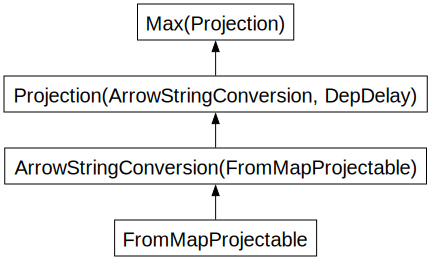

In [7]:
# notice the parallelism
result.visualize()

### Exercise 3

Calculate how many flights had been cancelled.

In [8]:
flights.Cancelled.value_counts().compute()

Cancelled
1      70931
0    2540961
Name: count, dtype: int64

In [9]:
len(flights[flights.Cancelled == 1])

70931

In [10]:
flights.Cancelled.sum().compute()

np.int64(70931)

### Exercise 4 

In total, how many non-canceled flights were taken from each airport?

*Hint*: use [groupby](https://pandas.pydata.org/pandas-docs/stable/groupby.html).

In [11]:
flights[flights.Cancelled == 0].groupby("Origin")["Origin"].count().compute()

Origin
EWR    1139451
JFK     427243
LGA     974267
Name: Origin, dtype: int64

### Exercise 5

What was the average departure delay from each airport?

In [12]:
flights.groupby("Origin")["DepDelay"].mean().compute()

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### Exercise 6 

What day of the week has the worst average departure delay?

In [13]:
delays = flights.groupby("DayOfWeek")["DepDelay"].mean().compute()
delays.sort_values(ascending=False)
delays.sort_values(ascending=False).index[0]

np.int64(5)

## Sharing Intermediate Results

When computing all of the above, we sometimes did the same operation more than once. For most operations, `dask.dataframe` stores the arguments, allowing duplicate computations to be shared and only computed once.

For example, let's compute the mean and standard deviation for departure delay of all non-canceled flights. Since Dask operations are lazy, those values aren't the final results yet. They're just the steps required to get the result.

If you compute them with two calls to compute, there is no sharing of intermediate computations.

In [14]:
non_canceled = flights[flights.Cancelled == 0]
mean_delay = non_canceled.DepDelay.mean()
std_delay = non_canceled.DepDelay.std()

In [15]:
%%time

mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

CPU times: user 107 ms, sys: 21.2 ms, total: 128 ms
Wall time: 997 ms


### `dask.compute`

But let's try by passing both to a single `compute` call.

In [16]:
import dask

In [17]:
%%time

mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: user 62.6 ms, sys: 13.1 ms, total: 75.7 ms
Wall time: 511 ms


Using `dask.compute` takes roughly 1/2 the time. This is because the task graphs for both results are merged when calling `dask.compute`, allowing shared operations to only be done once instead of twice. In particular, using `dask.compute` only does the following once:

- the calls to `read_csv`
- the filter (`flights[flights.Cancelled == 0]`)
- some of the necessary reductions (`sum`, `count`)

## `.persist()`

While using a distributed scheduler (you will learn more about schedulers in the upcoming notebooks), you can keep some _data that you want to use often_ in the _distributed memory_. 

`persist` generates "Futures" (more on this later as well) and stores them in the same structure as your output. You can use `persist` with any data or computation that fits in memory.

If you want to analyze data only for non-canceled flights departing from JFK airport, you can either have two compute calls like in the previous section:

In [18]:
non_cancelled = flights[flights.Cancelled == 0]
flights_jfk = non_cancelled[non_cancelled.Origin == "JFK"]

In [19]:
%%time
flights_jfk.DepDelay.mean().compute()
flights_jfk.DepDelay.sum().compute()

CPU times: user 134 ms, sys: 25.9 ms, total: 160 ms
Wall time: 1.11 s


np.float64(4422520.0)

Or, consider persisting that subset of data in memory.


In [20]:
flights_jfk = flights_jfk.persist()

In [21]:
%%time
flights_jfk.DepDelay.mean().compute()
flights_jfk.DepDelay.std().compute()

CPU times: user 61.9 ms, sys: 15.2 ms, total: 77.1 ms
Wall time: 549 ms


np.float64(31.242509798271147)

Analyses on this persisted data is faster because we are not repeating the loading and selecting (non-canceled, JFK departure) operations.

### Exercise 7

Find what airport has the most cancelled flights and what day of the week has the most cancelled flights. Use `.persist()` in the course of these manipulations.

## Close you local Dask Cluster

It's good practice to always close any Dask cluster you create:

In [22]:
client.shutdown()